In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:500px; }</style>"));
push!(LOAD_PATH, "../src");

HTML{String}("<style>.rendered_html.text_cell_render {max-width:500px; }</style>")

In [7]:
#nbx
using BenchmarkTools;
using Colors, Plots;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using GridSlam
using Geometry
using MyUtils
include("src/sensor.jl");

In [8]:
unstack(x::Matrix) = [x[i,:] for i=1:size(x,1)]
argdiffs(bs::Array{T,1}) where T <: Real = Tuple(map(b -> Bool(b) ? UnknownChange() : NoChange(), bs));

In [9]:
include("src/load_data.jl");
_fov = 2π
_as = [range(-_fov/2, _fov/2, 361)...];

Loading `../data/data_4.jld2` ...

	_segs 	Vector{Segment}
	_boxes 	Vector{Segment}
	_xs 	Vector{Vector{Float64}}
	_hds 	Vector{Float64}
	_ps 	Vector{Pose}
	_dxs 	Vector{Vector{Float64}}
	_dhds 	Vector{Float64}
	_us 	Vector{Control}
	_T 	Int64


In [10]:
using CUDA
segs_  = CuArray(stack(Vector.(_segs)));
boxes_ = CuArray(stack(Vector.(_boxes)));
ps_    = CuArray(stack(Vector.(_ps)));
as_    = CuArray(_as);

In [11]:
zs_ = cast_cu(ps_, vcat(segs_, boxes_); fov=_fov)
_zs = unstack(Array(zs_));

## Plotting

In [12]:
function Plots.plot!(p::Pose; r=0.5, args...)
    plot!([p.x, p.x + r*unit_vec(p.hd)]; args...)
end

function Plots.plot!(ps::Vector{Pose}, cs::Vector{RGBA{Float64}}; r=0.5, args...)
    myplot=nothing
    for (p,c) in zip(ps,cs)
        myplot = plot!([p.x, p.x + r*unit_vec(p.hd)];c=c, args...)
    end
    return myplot
end

function Plots.plot!(ps::Vector{Pose}; r=0.5, args...)
    myplot=nothing
    for p in ps
        myplot = plot!([p.x, p.x + r*unit_vec(p.hd)]; args...)
    end
    return myplot
end

## Distributions we need

In [13]:
#nbx
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src")
using GenDistributionZoo: ProductDistribution, diagnormal

mvuniform = ProductDistribution(uniform);
mvuniform(zeros(2), ones(2))

2-element Vector{Float64}:
 0.1096969956052668
 0.04749809193479204

## Model parts

### Pose-prior model

In [14]:
#nbx --fname="src/pose_prior_model.jl"
_bb = bounding_box(_segs);

"""
    p = pose_prior_model(p=nothing, x_noise=0.25, hd_noise=45.)

Model depends on global variable `_segs`.
"""
@gen function pose_prior_model(p=nothing, x_noise=0.25, hd_noise=45/360*2π, bb=_bb)
    if p == nothing
        x  ~ mvuniform(bb...)
        hd ~ uniform(0,2π)
    else
        x  ~ diagnormal(p.x, [x_noise, x_noise])
        hd ~ normal(p.hd, hd_noise)
    end
    return Pose(x, hd)
end;

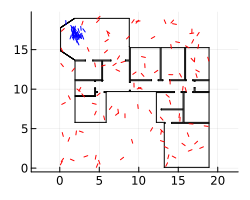

In [15]:
ps = [pose_prior_model(nothing) for t=1:100]
qs = [pose_prior_model(_ps[1], .5, 15/360*2π) for t=1:50]

# ----------------------
plot(size=(250,200), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
plot!(ps,c=:red)
plot!(qs,c=:blue)

### Control Prior

In [16]:
#nbx
@gen function control_prior_model(dx_noise=0.25, dhd_noise=45/360*2π)
    dx  ~ diagnormal([0;0], [dx_noise, dx_noise])
    dhd ~ normal(0, dhd_noise)
    return Control(dx, dhd)
end;

In [17]:
control_prior_model(0.10, 45/360*2π)

Control([0.005548899566875717, 0.028083777147270356], 0.1352834979508879)

### Motion model

In [18]:
#nbx --fname="src/motion_model.jl"
"""
    p′ = motion_model(p, u, x_noise=0.25, hd_noise=22.5)

Sample a new pose `p′` given the previous pose `p`, 
some control data `u = Control(dx, dhd)`, and noise levels
`x_noise` and `hd_noise` (in degrees).
"""
@gen function motion_model(p, u, x_noise=0.25, hd_noise=45/360*2π)
    dx, dhd = u.dx, u.dhd
    x   ~ diagnormal(p.x  + dx , [x_noise, x_noise])
    hd  ~ normal(p.hd + dhd, hd_noise)
    return p = Pose(x, hd)
end;

### Sensor model

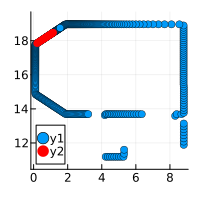

In [19]:
w = 20
m = 2*w+1
t = 1
i = 40

z_       = cast_cu(ps_, vcat(segs_))
z_tilde_ = slw_cu!(z_, w; blockdims=(8,8,4))

z       = Array(z_)
z_tilde = Array{Float64}(z_tilde_)

ys        = polar_inv(z[t,:], _as)
ys_tilde  = polar_inv(z_tilde[t,i,:], _as[i-w:i+w])

# ----------------------
plot(size=(200,200), aspect_ratio=:equal)
scatter!(ys.*_ps[t])
scatter!(ys_tilde.*_ps[t], c=:red, markerstrokewidth=0)

In [20]:
#nbx
@gen function sensor_model_cu(p, segs_, w, s_noise, outlier, outliver_vol=1.0)
    p_  = CuArray(Vector(p))
    ps_ = reshape(p_, 1, 3)
    zs_ = cast_cu(ps_, segs_; fov=_fov)
    
    y_tilde_ = get_ys_tilde_cu(zs_, as_, w)[1,:,:,:]
    x ~ sensordist_cu(y_tilde_, s_noise, outlier, outliver_vol)
    
    return x
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any, Any, Any, Any], true, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, Some(1.0)], var"##sensor_model_cu#397", Bool[0, 0, 0, 0, 0, 0], false)

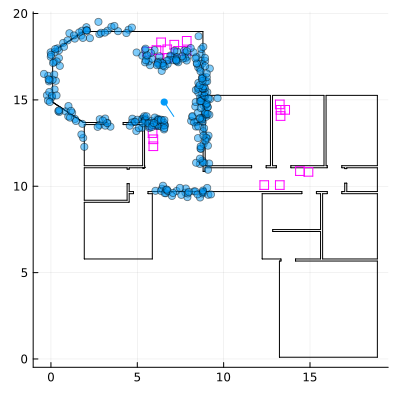

In [21]:
w            = 5
s_noise      = 0.2
outlier      = 0.1
outliver_vol = 1.0

t = 7

x = sensor_model_cu(_ps[t], vcat(segs_,boxes_), w, s_noise, outlier, outliver_vol)

# -------------------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
plot!(_boxes, c=:magenta)
scatter!(x.*_ps[t], c=col[1], alpha=0.5)
scatter!(_ps[t], c=col[1])

## Static Model

In [22]:
#nbx
@gen function slam_kernel(t, state, m, us, x_noise, hd_noise, w, s_noise, outlier, outliver_vol)
    
        p,_ = state
        u = us[t]
    
        p  = {:pose}   ~ motion_model(p, u, x_noise, hd_noise)
        x  = {:sensor} ~ sensor_model_cu(p, m, w, s_noise, outlier, outliver_vol)
        
    return (p, x)
end

slam_chain = Gen.Unfold(slam_kernel)
Gen.@load_generated_functions

In [23]:
#nbx
"""
    [(p,z),...] = static_slam_model(T, ...)

Static SLAM model ...
"""
@gen (static) function static_slam_model(T, 
        m,
        us, 
        p0, x0_noise, hd0_noise,  
        x_noise, hd_noise, 
        w, s_noise, outlier, outliver_vol)
    
    # Start the Markov chain; 
    # No motion, just the prior
    p  = { :pose   } ~ pose_prior_model(p0, x0_noise, hd0_noise)
    x  = { :sensor } ~ sensor_model_cu(p, m, w, s_noise, outlier, outliver_vol) # GPU accelerated
    
    # Unfold the MArkov chain
    chain ~ slam_chain(T, (p, nothing), m, us, 
        x_noise, hd_noise, 
        w, s_noise, outlier, outliver_vol)
    
    return [(p,x);chain]
end

Gen.@load_generated_functions

In [24]:
#nbx
function constraints(t::Int, _zs, _as)
    ch = choicemap()
    if t==0
        addr  = :sensor => :x
    else
        addr  = :chain => t => :sensor => :x
    end
    n = length(_zs[t+1])
    x = polar_inv(_zs[t+1],_as)
    ch[addr] = x
    return ch
end

constraints (generic function with 1 method)

In [25]:
#nbx
get_pose(tr,t)     = tr[][t][1]
get_last_pose(tr)  = tr[][end][1]
get_first_pose(tr) = get_pose(tr,1)

get_x(tr,t)     = tr[][t][2]
get_first_x(tr) = get_x(tr,1)

get_first_x (generic function with 1 method)

### Example

In [28]:
T = 0

p0 = _ps[1]
x0_noise = 1.00
hd0_noise = 25/360*2π

x_noise  = 0.1
hd_noise = 10/360*2π

wind = 10
s_noise = 0.1
outlier = 0.1
outlier_vol=1.0

ch = constraints(0,_zs,_as)

idealized = true

m_ = idealized ? segs_ : vcat(segs_,boxes_);

args = (
    m_,                                    # Map
    _us,                                   # Controls
    p0, x0_noise, hd0_noise,               # Pose prior model
    x_noise, hd_noise,                     # Motion model
    wind, s_noise, outlier, outliver_vol   # Sensor model
)


@time tr, w = generate(static_slam_model, (T, args...), ch);

  0.001267 seconds (1.14 k allocations: 71.266 KiB)


In [29]:
trs, ws, lml = importance_sampling(static_slam_model, (T, args...), ch, 1_000);

good = ws .!= -Inf 
trs = trs[good]
ws = ws[good]

perm = sortperm(ws)
trs = trs[perm]
ws = ws[perm]

ps = get_first_pose.(trs);

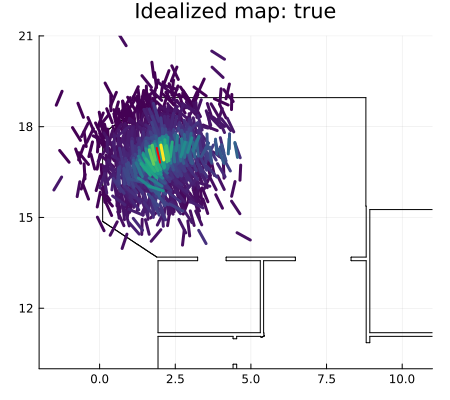

In [30]:

cs = cgrad(:viridis)[peak_to_peak(ws)]
# ----------------------
myplot = plot(size=(450,400), 
    title = "Idealized map: $(idealized)",
    aspect_ratio=:equal, legend=nothing, xlim=(-2,11),ylim=(10,21))
plot!(_segs, c=:black)
plot!(ps, cs, r=0.5, linewidth=3)
plot!(p0, c=:red, r=0.5, linewidth=2)
savefig("_imgs/pose_prior_idealized=$(idealized).png") 
myplot

### PF example

In [31]:
function perturb(u::Control, x_noise, hd_noise)
    dx  = u.dx  + diagnormal([0.,0.], [x_noise, x_noise])
    dhd = u.dhd + normal(0, hd_noise)
    return Control(dx,dhd)
end

perturb (generic function with 1 method)

In [60]:
idealized = false
m_        = idealized ? segs_ : vcat(segs_, boxes_);

p0 = _ps[1]
x0_noise  = .2
hd0_noise = 10/360*2π

x_noise  = 0.5
hd_noise = 15/360*2π

w = 10
s_noise = 0.1
outlier = 0.0
outlier_vol = 1.0


us_noisy = perturb.(_us, x_noise, hd_noise)

args = (
    m_,                                    # Map
    us_noisy,                              # Controls
    p0, x0_noise, hd0_noise,               # Pose prior model
    x_noise, hd_noise,                     # Motion model
    wind, s_noise, outlier, outliver_vol   # Sensor model
);

#### Noisy controls

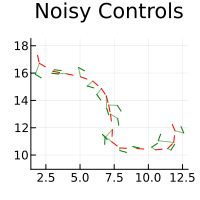

In [61]:
qs = [Pose(p.x + u.dx, p.hd + u.dhd) for (p,u) in zip(_ps[1:end-1],us_noisy)];
# ---------------------
myplot = plot(size=(200,200), 
    title="Noisy Controls",
    aspect_ratio=1., legend=nothing)
# plot!(_segs, c=:black)
plot!(_ps[1], c=:red)
for (p,q) in zip(_ps[2:end],qs)
    plot!(p, c=:red)
    plot!(q, c=:green)
    plot!([p.x,q.x], c=:green, alpha=0.5)
end
myplot

#### Run PF

In [62]:
N = 1_000


ch    = constraints(0,_zs,_as);
state = initialize_particle_filter(static_slam_model, (0, args...), ch, N);

r = maybe_resample!(state)
# println("$(r), $(length(Set(state.parents)))")

diffs = argdiffs([1; fill(0,length(args))])
for t=1:_T-1
    ch = constraints(t,_zs,_as);    
    @time dw, = particle_filter_step!(state, (t, args...), diffs, ch)
    r = maybe_resample!(state; ess_threshold=N)
#     println("$(r), $(length(Set(state.parents)))")
end

true, 1
  0.863945 seconds (1.20 M allocations: 75.503 MiB)
true, 1
  1.094593 seconds (1.33 M allocations: 79.522 MiB, 6.57% gc time)
true, 1
  0.826467 seconds (1.20 M allocations: 75.564 MiB)
true, 1
  1.080589 seconds (1.32 M allocations: 79.216 MiB, 6.30% gc time)
true, 1
  0.840619 seconds (1.20 M allocations: 75.610 MiB)
true, 1
  1.080272 seconds (1.32 M allocations: 79.427 MiB, 5.53% gc time)
true, 1
  0.896188 seconds (1.20 M allocations: 75.655 MiB)
true, 1
  1.116948 seconds (1.32 M allocations: 79.458 MiB, 5.40% gc time)
true, 1
  0.874070 seconds (1.20 M allocations: 75.702 MiB)
true, 1
  1.069416 seconds (1.32 M allocations: 79.508 MiB, 5.59% gc time)
true, 1
  0.837846 seconds (1.20 M allocations: 75.747 MiB)
true, 1
  1.119739 seconds (1.32 M allocations: 79.553 MiB, 5.67% gc time)
true, 1
  0.881524 seconds (1.20 M allocations: 75.793 MiB)
true, 1
  1.163772 seconds (1.32 M allocations: 79.597 MiB, 5.55% gc time)
true, 1
  0.912582 seconds (1.20 M allocations: 75.839 

In [63]:
function plot_slam_trace!(tr; args...)
    ps = [r[1] for r in tr[]]
    xs = [r[2] for r in tr[]]
    myplot = plot!(ps, c=col[1]; args...)
    for (x,p) in zip(xs,ps)
        myplot = scatter!(x.*p, c=col[1], markersize=2; args...)
    end
    return myplot
end

plot_slam_trace! (generic function with 1 method)

In [64]:
using Fmt
nice_f(x) = f"{$x:0.2f}"
nice_f(0.123)

"0.12"

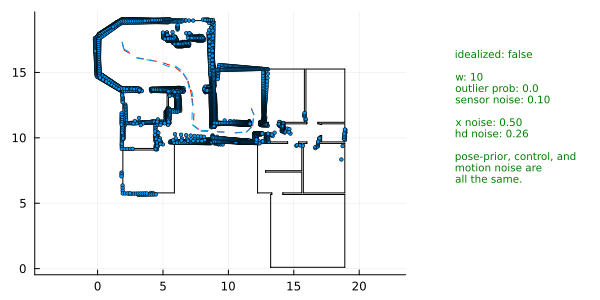

In [65]:
trs, ws = state.traces, state.log_weights
scores = get_score.(trs)
perm = sortperm(scores)
trs  = trs[perm]
ws   = ws[perm];


myplot = plot(aspect_ratio=1., legend=nothing)
plot!(_segs, c=:black)
plot!(_ps, c=:red)
plot_slam_trace!(trs[end])

mytext = plot(showaxis = false, ticks = false, xlims=(-1,11), ylims=(-1,11), )
annotate!(1, 10, text("""
idealized: $(idealized)
        
w: $(w)
outlier prob: $(outlier)
sensor noise: $(nice_f(s_noise))
        
x noise: $(nice_f(x_noise))
hd noise: $(nice_f(hd_noise))
        
pose-prior, control, and 
motion noise are 
all the same.
""", 7, :left, :top, :green)
)



plot(myplot, mytext, layout=grid(1, 2, widths=[0.7,0.3]), size=(600,300))

## SMC grid proposal

### Pose grid

In [66]:
dx  = 0.1
dhd = 0.1
k = 3
collect(range(-dx*(k-1)/2, dx*(k-1)/2, k))

3-element Vector{Float64}:
 -0.1
  0.0
  0.1

In [67]:
CUDA.range(-delta_x,  delta_x, k)

LoadError: UndefVarError: delta_x not defined

In [68]:
#nbx
"""
    ps_ = pose_grid(p, k, dx, dhd)

Returns CuArray of pose vectors (k^3, 3).
"""
function pose_grid(p, k, dx, dhd)

#     dx1_ = CUDA.collect(CUDA.range(- dx*(k-1)/2,  dx*(k-1)/2, k))
#     dx2_ = CUDA.collect(CUDA.range(- dx*(k-1)/2,  dx*(k-1)/2, k))
#     dhd_ = CUDA.collect(CUDA.range(-dhd*(k-1)/2, dhd*(k-1)/2, k))
    dx1_ = CUDA.collect(CUDA.range(- dx,  dx, k))
    dx2_ = CUDA.collect(CUDA.range(- dx,  dx, k))
    dhd_ = CUDA.collect(CUDA.range(-dhd, dhd, k))
    dx1_ = CuArray(dx1_)
    dx2_ = CuArray(dx2_)
    dhd_ = CuArray(dhd_)
    dx1_ = CUDA.repeat(reshape(dx1_, k,1,1), 1,k,k)
    dx2_ = CUDA.repeat(reshape(dx2_, 1,k,1), k,1,k)
    dhd_ = CUDA.repeat(reshape(dhd_, 1,1,k), k,k,1)

    ps_ = CUDA.cat(dx1_, dx2_, dhd_, dims=4)
    ps_ = reshape(ps_, :,3)
    ps_ = ps_ .+ reshape(CuArray(Vector(p)),1,3)
    return ps_
end

pose_grid

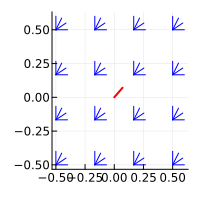

In [69]:
p = Pose([0;0],π/4)

dx  = .5
dhd = 45/360*2π
k   = 4
ps_ = pose_grid(p, k, dx, dhd)
ps  = [Pose(Vector(v)) for v in eachrow(Array(ps_))]

# -----------------------------
mypl = plot(size=(200,200), legend=nothing)
plot!(ps, c=:blue, r=0.1, linewidth=1)
plot!(p, c=:red, r=0.1, linewidth=2)
mypl

### Eval pose grid

Needs raycaster and gm-centers and sensor smc logpdf from "src/sensor.jl".

In [216]:
#nbx
"""
"""
function eval_poses(
            ps_::CuArray,
            x::Matrix, 
            segs_, as_, w::Int, 
            s_noise::Float64, outlier::Float64, outlier_vol::Float64=1.0; sorted=false)
    
    # Compute measurements and gm centers
    zs_      = cast_cu(ps_, segs_)
    ys_tilde_ = get_ys_tilde_cu(zs_, as_, w)
        
    # Evaluate the gm's
    x_ = CuArray(x)
    log_p_ = sensor_smc_logpdf_cu(x_, ys_tilde_, s_noise, outlier, outlier_vol);
    
    # Back to CPU
    ps    = Vector.(eachrow(Array(ps_)))
    log_p = Array(log_p_)

    
    # Sort by log prob
    # and return 
    if sorted
        perm  = sortperm(log_p)
        log_p = log_p[perm]
        ps    = ps[perm]
    end
    
    return ps, log_p
end

eval_poses

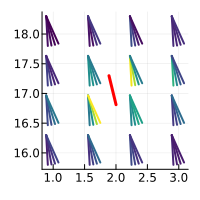

In [217]:
p = _ps[1]
dx  = 1.
dhd = 10/360*2π
k   = 4
ps_ = pose_grid(p, k, dx, dhd)
ps  = [Pose(Vector(v)) for v in eachrow(Array(ps_))]

x = stack(polar_inv(_zs[1],_as))

s_noise = 0.2
outlier = 0.1
outlier_vol = 1.0
w = 4

ps, log_ps = eval_poses(ps_, x, vcat(segs_,boxes_), as_, w, s_noise, outlier, outlier_vol)

cs = cgrad(:viridis)[peak_to_peak(log_ps)]
# -----------------------------
mypl = plot(size=(200,200), legend=nothing)
plot!(Pose.(ps), cs; r=.5, linewidth=2)
plot!(p, c=:red, r=.5, linewidth=3)
mypl

### Grid proposal



In [582]:
#nbx
function filter_infs(ps, log_p)
    good = log_p .!= -Inf
    return ps[good], log_p[good]
end

@dist function labeled_cat(labels, probs)
    index = categorical(probs)
    labels[index]
end

@gen function grid_proposal(p::Pose, x::Matrix{Float64}, 
            k, dx, dhd,
            segs_, as_, w::Int, 
            s_noise::Float64, outlier::Float64, outlier_vol::Float64=1.0)
    
    ps_        = pose_grid(p, k, dx, dhd)
    ps, log_ps = eval_poses(ps_, x, segs_, as_, w, s_noise, outlier, outlier_vol)
    
#     ps, log_p = filter_infs(ps, log_ps)
    
    probs = exp.(log_ps .- logsumexp(log_ps))
    probs = probs/sum(probs)
    j = {:j} ~ categorical(probs)
    
    return Pose(ps[j]), log_ps[j], (ps, log_ps)
end


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Pose, Matrix{Float64}, Any, Any, Any, Any, Any, Int64, Float64, Float64, Float64], true, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, Some(1.0)], var"##grid_proposal#2075", Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], false)

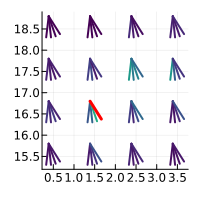

In [583]:
p = _ps[1]
dx  = 1.5
dhd = 20/360*2π
k   = 4
ps_ = pose_grid(p, k, dx, dhd)
ps  = [Pose(Vector(v)) for v in eachrow(Array(ps_))]

x = stack(polar_inv(_zs[1],_as))

s_noise = 0.1
outlier = 0.1
outlier_vol = 1.00
w = 10

q, log_q, (ps, log_ps) = grid_proposal(p, x, k, dx, dhd, segs_, as_, w, s_noise, outlier, outlier_vol)

probs = exp.(log_ps .- logsumexp(log_ps))

cs = cgrad(:viridis)[peak_to_peak(log_ps)]
# cs = cgrad(:viridis)[probs]
# -----------------------------
mypl = plot(size=(200,200), legend=nothing)
plot!(Pose.(ps), cs; r=.5, linewidth=2)
# plot!(p, c=:red, r=.5, linewidth=3)
plot!(q, c=:red, r=.5, linewidth=3)
mypl

### Iterated Proposal

In [599]:
#nbx
@gen function iterated_proposal(p::Pose, x::Matrix, 
                                grid_k, grid_dx, grid_dhd,
                                segs_, as_, 
                                w, s_noise, outlier, outlier_vol)
    
    n = length(w)
    
    ps = Pose[]
    Ls = []
    log_ps = [] 
    for i=1:n
        args = (
            p, x, 
            grid_k[i], grid_dx[i], grid_dhd[i],
            segs_, as_, 
            w[i], s_noise[i], outlier[i], outlier_vol[i])
        
        p, log_p, (_, ls) = {i} ~ grid_proposal(args...)
        push!(ps, p)
        push!(log_ps, log_p)
        push!(Ls, ls)
    end
    
    return p, ps, log_ps, Ls
end;

In [600]:
idealized = true
m_        = idealized ? segs_ : vcat(segs_, boxes_);

In [601]:
using LinearAlgebra: norm

[1.7219761904761894, 17.131857142857147, -1.198553374408151]
[1.8701243386243376, 17.280005291005295, -1.327837022704027]
0.24619100169612881


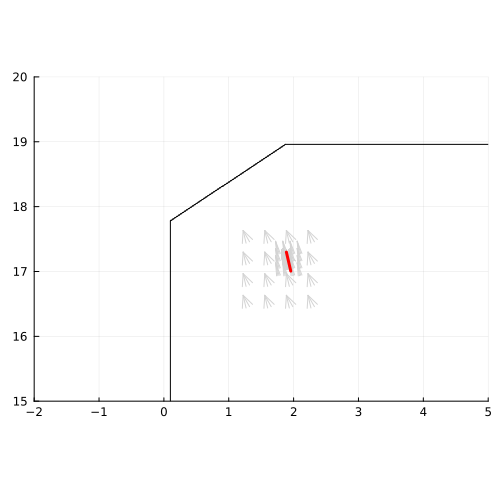

In [602]:

p = _ps[1]
x = stack(polar_inv(_zs[1],_as))

n = 3

k   = fill(4, n)
dx  = .5 ./ (k*0.75) .^ collect(range(0,n-1))
dhd = 25/360*2π ./ (k*0.75) .^ collect(range(0,n-1))


s_noise     = fill(0.1, n)
outlier     = fill(0.1, n)
outlier_vol = fill(1., n)
w           = fill(10, n)

grid_args = (k, dx, dhd, m_, as_, w, s_noise, outlier, outlier_vol)

q, ps, log_p, log_ps = iterated_proposal(p, x, grid_args...)


err = norm(Vector(normalize!(ps[1]/ps[end])))
println(Vector(ps[1]))
println(Vector(ps[end]))
println(err)


# -----------------------------
mypl = plot(size=(500,500), legend=nothing, aspect_ratio=:equal,
    xlim=(-2,5), ylim=(15,20))
plot!(_segs, c=:black)

for i=1:n
    gs_ = pose_grid(ps[i], k[i], dx[i], dhd[i])
    gs  = [Pose(Vector(v)) for v in eachrow(Array(gs_))]
    plot!(gs; r=.2, linewidth=1, c=:lightgray)
end
plot!(p, c=:red, r=.3, linewidth=3)
mypl

In [603]:
#nbx
function extend(tr, u, obs, grid_args)

    args  = get_args(tr)    
    diffs = argdiffs([1;fill(0,length(args))])
    t = args[1]    
    x = stack(obs[:chain => t+1 => :sensor => :x])
    
    p = get_last_pose(tr)
    p = Pose(p.x + u.dx, p.hd + u.dhd)
    proposal_tr = simulate(iterated_proposal, (p, x, grid_args...));
    proposal_sc = get_score(proposal_tr)
    p′, ps′, log_ps′,  = proposal_tr[];
    
    
    ch = choicemap()
    ch[:chain => t+1 => :pose => :x]  = p′.x
    ch[:chain => t+1 => :pose => :hd]  = p′.hd
        
    tr′,w′,_,_ = Gen.update(tr,(t+1,args[2:end]...),diffs,merge(obs,ch))
    
    return tr′, w′ - proposal_sc, ps′, log_ps′
    
end

extend (generic function with 1 method)

## SMC model

In [604]:
idealized = true
m_        = idealized ? segs_ : vcat(segs_, boxes_);

p0 = _ps[1]
x0_noise  = .2
hd0_noise = 10/360*2π

x_noise  = 0.5
hd_noise = 20/360*2π

w = 10
s_noise = 0.1
outlier = 0.1
outlier_vol = 1.0


# us_noisy = perturb.(_us, x_noise, hd_noise)

args = (
    m_,                                    # Map
    us_noisy,                              # Controls
    p0, x0_noise, hd0_noise,               # Pose prior model
    x_noise, hd_noise,                     # Motion model
    wind, s_noise, outlier, outliver_vol   # Sensor model
);

In [682]:
n = 3

k   = fill(5, n)
dx  = 1. ./ (k*0.75) .^ collect(range(0,n-1))
dhd = 35/360*2π ./ (k*0.75) .^ collect(range(0,n-1))


s_noise     = [range(0.5,0.1,n)...]
outlier     = fill(0.1, n)
outlier_vol = fill(1., n)
w           = fill(20, n)

grid_args = (k, dx, dhd, m_, as_, w, s_noise, outlier, outlier_vol)

times= []
ch = constraints(0,_zs,_as);
tr, w = generate(static_slam_model, (0, args...), ch);
for t=1:_T-1
    ch = constraints(t,_zs,_as);
    time = @elapsed tr, w, ps, log_ps = extend(tr, us_noisy[t], ch, grid_args)
    push!(times, time*1000)
end

In [683]:
using StatsBase: mean

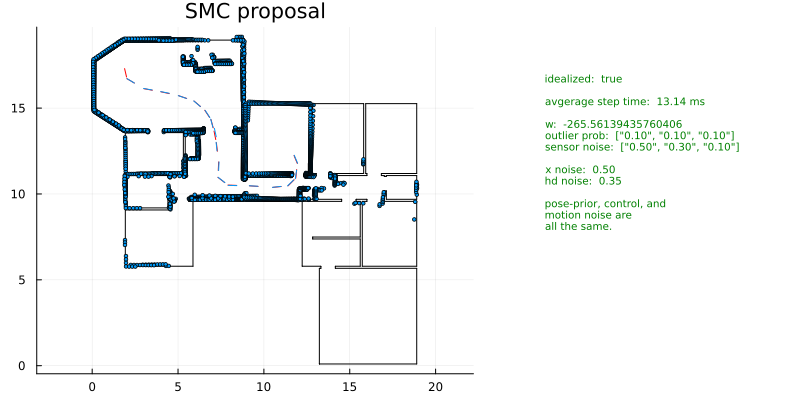

In [684]:
function plot_slam_trace_2!(tr; args...)
    ps = [r[1] for r in tr[][2:end]]
    xs = [r[2] for r in tr[][2:end]]
    myplot = plot!(ps, c=col[1]; args...)
    for (x,p) in zip(xs,ps)
        myplot = scatter!(x.*p, c=col[1], markersize=2; args...)
    end
    return myplot
end

myplot = plot(aspect_ratio=1., legend=nothing, 
    title="SMC proposal"
)
plot!(_segs, c=:black)
plot!(_ps, c=:red)
plot_slam_trace_2!(tr)

mytext = plot(showaxis = false, ticks = false, xlims=(-1,11), ylims=(-1,11), )
annotate!(1, 10, text("""
idealized:  $(idealized)
        
avgerage step time:  $(nice_f(mean(times))) ms
        
w:  $(w)
outlier prob:  $(nice_f.(outlier))
sensor noise:  $(nice_f.(s_noise))
        
x noise:  $(nice_f(x_noise))
hd noise:  $(nice_f(hd_noise))
        
pose-prior, control, and 
motion noise are 
all the same.
""", 7, :left, :top, :green)
)



plot(myplot, mytext, layout=grid(1, 2, widths=[0.6,0.4]), size=(800,400))

## Kidnapped Robot

In [608]:
using LinearAlgebra: norm

function GridSlam.normalize!(p::Pose)
    p.hd = mod(p.hd + π, 2π) - π
    return p
end

16.53 ms
[7.367023809523809, 11.865047619047623, -1.6207547225168397]
[7.361410552835693, 11.855397654032073, 4.653449447881116]
0.014327989856862787


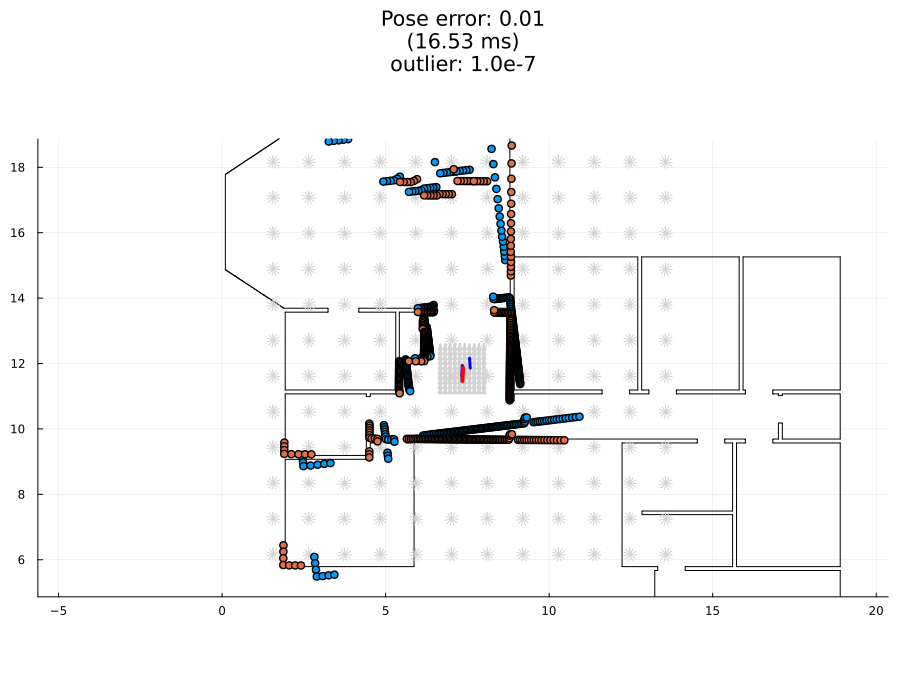

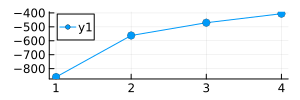

In [674]:
t = 11
p0 = _ps[t]
x = stack(polar_inv(_zs[t],_as))

# Grid args
n   = 4
k   = Int.(ceil.(range(12,5,n)))
dx  = 6. ./ (k*0.9) .^ collect(range(0,n-1))
# dx  = [range(5., 0.5, n)...]
# dhd = [range(π, 5/360*2π, n)...]
dhd = 180/360*2π ./ (k*0.9) .^ collect(range(0,n-1))
dhd = max.(dhd, 5/360*2π)


# s_noise     = [range(.6, 0.05, n)...]
# outlier     = fill(0.01, n)
# s_noise     = [range(.9, 0.1, n)...]
# outlier     = fill(0.1, n)
s_noise     = [range(.5, 0.1, n)...]
# outlier     = fill(0.0000001, n)
outlier     = [range(0.0000001, 0.1, n)...]
outlier_vol = fill(1., n)
w           = fill(10, n)

idealized = true
m_        = idealized ? segs_ : vcat(segs_, boxes_);

grid_args = (k, dx, dhd, m_, as_, w, s_noise, outlier, outlier_vol)


# p_tilde = Pose(p0.x + 3*(rand(2).-0.5),p0.hd + rand()*2π)

# Run grid search
time = @elapsed q, ps, log_ps, Ls = iterated_proposal(p_tilde, x, grid_args...)


err = norm(Vector(normalize!(p0/ps[end])))
println("$(nice_f(time*1_000)) ms")
println(Vector(p0))
println(Vector(ps[end]))
println(err)


# -----------------------------
mypl = plot(size=(900,700), legend=nothing, aspect_ratio=:equal,
    xlim=[-13,13].+ p0.x[1], ylim=[-7,7].+ p0.x[2],
    title="Pose error: $(nice_f(err))\n($(nice_f(time*1_000)) ms)\noutlier: $(outlier[1])",)
plot!(_segs, c=:black)



for i=1:n
    gs_ = pose_grid(ps[i], k[i], dx[i], dhd[i])
    gs  = [Pose(Vector(v)) for v in eachrow(Array(gs_))]
    
    plot!(gs; r=.2,c=:lightgray, linewidth=1)
    

end

scatter!(unstack(x).*ps[1], c=col[1])
scatter!(unstack(x).*ps[end], c=col[2])
plot!(ps, c=:blue, r=.3, linewidth=3)
plot!(ps[end], c=:blue, r=.3, linewidth=3)
plot!(p0, c=:red, r=.4, linewidth=4)
display(mypl)

plot(1:n, log_ps, marker=:o, size=(300,100))

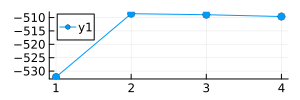

In [671]:
plot(1:n, log_ps, marker=:o, size=(300,100))

[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/tmp.gif


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/tmp.gif")
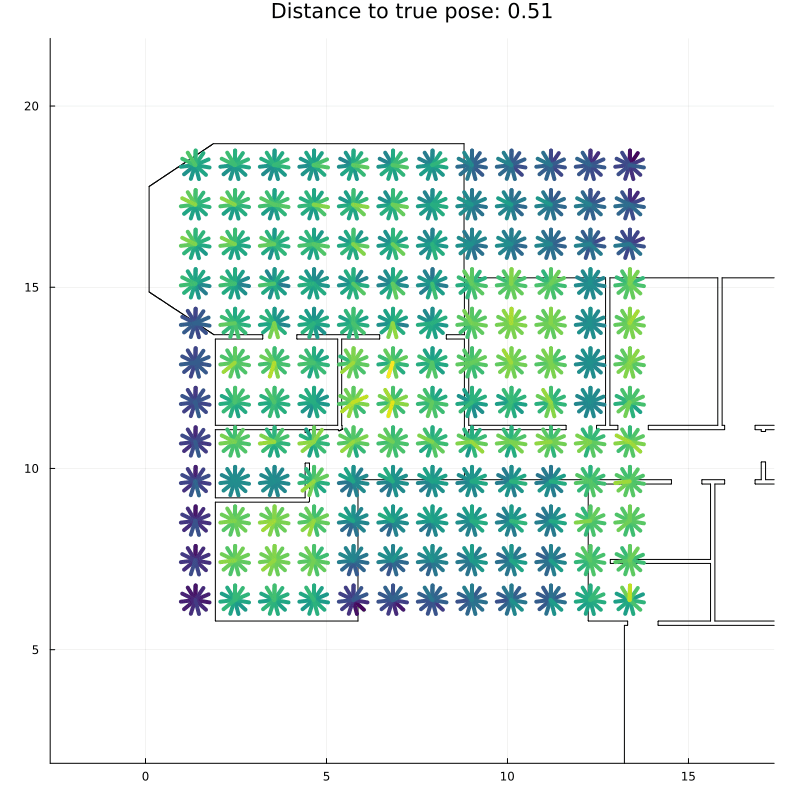

In [658]:
ani = Animation()
# -----------------------------
mypl = plot(size=(800,800), legend=nothing, aspect_ratio=:equal,
    xlim=[-5,5].+ p0.x[1], ylim=[-5,5].+ p0.x[2])
plot!(_segs, c=:black)

for i=1:n
    
    
    
    err = norm(Vector(normalize!(p0/ps[i])))
    
    delta = range(10,10, n)
#     q = ps[i]
    q = p0
    mypl = plot(size=(800,800), legend=nothing, aspect_ratio=:equal,
                xlim=[-delta[i],delta[i]].+ q.x[1], ylim=[-delta[i],delta[i]].+ q.x[2],
        title="Distance to true pose: $(nice_f(err))",
    )
    plot!(_segs, c=:black)
    
    gs_ = pose_grid(ps[i], k[i], dx[i], dhd[i])
    gs  = [Pose(Vector(v)) for v in eachrow(Array(gs_))]
    
    log_p = Ls[i]
    probs = exp.(log_p .- logsumexp(log_p))
    probs = probs/sum(probs)
    
    perm  = sortperm(log_p)
    log_p = log_p[perm]
    gs    = gs[perm]
    probs = probs[perm]
    
#     log_p = max.(log_p, -10_000)
    
    
    vs = log_p
#     vs = probs
    
    cs = cgrad(:viridis)[peak_to_peak(vs)]
    
#     plot!(gs;c=:lightgray, r=.4, linewidth=3, alpha=0.5)
#     plot!(p0, c=:red, r=.3, linewidth=3);
#     plot!(ps[2:i], c=:blue, r=.3, linewidth=3)
    
#     frame(ani, mypl)    
    
    plot!(gs, cs; r=.4, linewidth=4, alpha=1.)    
    
#     plot!(ps[2:i], c=:blue, r=.3, linewidth=3)
    
#     plot!(p0, c=:red, r=.4, linewidth=5);
#     plot!([p0.x + unit_vec(th) for th=range(0, 2π, 50)], c=:red, linewidth=5)
    
    frame(ani, mypl)
    
    
#     plot!(p0, c=:red, r=.3, linewidth=3);
#     plot!([p0.x + unit_vec(th) for th=range(0, 2π, 50)], c=:red, linewidth=5)
    
#     v = unit_vec(p0.hd)
#     plot!([p0.x + 0.8*v,p0.x + 1.2*v], c=:red, linewidth=5)
    
#     plot!(ps[2:i], c=:blue, r=.3, linewidth=3)
    
#     frame(ani, mypl)
    

#     plot!(ps[2:i+1], c=:blue, r=.3, linewidth=3)
    frame(ani, mypl)

end

# plot!(ps, c=:blue, r=.3, linewidth=2)
# plot!(ps[end], c=:blue, r=.3, linewidth=4)
plot!(p0, c=:red, r=.3, linewidth=2);
gif(ani, fps=4)